In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import random
import nltk
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Aquire the dataset

In [23]:
!gdown 1dANzxlEjeCEbveFOWWqzSG-niVx-vCgK

Downloading...
From: https://drive.google.com/uc?id=1dANzxlEjeCEbveFOWWqzSG-niVx-vCgK
To: /content/sentiment_analysis.csv
100% 1.10M/1.10M [00:00<00:00, 64.9MB/s]


In [66]:
df = pd.read_csv('/content/sentiment_analysis.csv', index_col='id')
df.info()
print(df[:5])

<class 'pandas.core.frame.DataFrame'>
Index: 7920 entries, 1 to 7920
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7920 non-null   int64 
 1   tweet   7920 non-null   object
dtypes: int64(1), object(1)
memory usage: 185.6+ KB
    label                                              tweet
id                                                          
1       0  #fingerprint #Pregnancy Test https://goo.gl/h1...
2       0  Finally a transparant silicon case ^^ Thanks t...
3       0  We love this! Would you go? #talk #makememorie...
4       0  I'm wired I know I'm George I was made that wa...
5       1  What amazing service! Apple won't even talk to...


# Process the dataset

In [67]:
tweets = df['tweet'].to_list()
y = df['label'].to_numpy()

def normalize_text(text):
  # remove the RT
  text = re.sub(r'^RT\s?', '', text)

  # remove hyperlink
  text = re.sub(r'https ?:\/\/.*[\ r\n]*', '', text)

  # remove punctuation
  text = re.sub(r'[^\w\s]', '', text)

  # tokenize
  tokenizer = TweetTokenizer(
      preserve_case=True,
      strip_handles=True,
      reduce_len=True
  )
  tokens = tokenizer.tokenize(text)

  return tokens

# Create a dictionary, that count how many time ('hello', 1) and ('hello', 0) appear
def get_word_case_freq(all_tweets, labels):
  word_case_freq = dict()

  for tweet, label in zip(all_tweets, labels):
    text_tokens = normalize_text(tweet)
    for token in text_tokens:
        if (token, label) in word_case_freq:
          word_case_freq[(token, label)] += 1
        else:
          word_case_freq[(token, label)] = 1

  return word_case_freq

# For a tweet get the transformed vector of that tweet
def get_sample_vector(tweet, word_case_freq):
  vector = np.array([1, 0, 0])
  tokens = normalize_text(tweet)

  for token in tokens:
    vector[1] += word_case_freq[(token, 1)] if (token, 1) in word_case_freq else 0
    vector[2] += word_case_freq[(token, 0)] if (token, 0) in word_case_freq else 0

  return vector

def get_X(tweets, labels):
  X = []
  word_case_freq = get_word_case_freq(tweets, labels)

  for tweet in tweets:
    X.append(get_sample_vector(tweet, word_case_freq))

  return np.array(X)


In [86]:
X = get_X(tweets, y)
X = X.astype(np.float32)

# Train val test

In [88]:
random_state = 2
test_ratio = 0.125
val_ratio = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    shuffle=is_shuffle,
    test_size=test_ratio,
    random_state=random_state
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    shuffle=is_shuffle,
    test_size=val_ratio,
    random_state=random_state
)

# Normalize the data

In [89]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])

# Training

In [97]:
def predict(X, theta):
  return sigmoid(np.dot(X, theta))

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def compute_loss(y_hat, y):
  y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
  return (-y*np.log(y_hat) - (1-y)*np.log(1 - y_hat)).mean()

def compute_gradient(X, y, y_hat):
  return np.dot(X.T, y_hat - y) / X.shape[0]

def compute_accuracy(y, y_hat):
  y_pred = np.round(y_hat)
  return np.mean((y_pred == y))

def update_theta(theta, gradient, lr):
  return theta - lr * gradient

In [102]:
lr = 0.01
epochs = 200
batch_size = 128
np.random.seed(random_state)
theta = np.random.uniform(
    size=X.shape[1]
)

train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  train_e_losses = []
  train_e_accs = []
  val_e_losses = []
  val_e_accs = []

  for i in range(0, X_train.shape[0], batch_size):
    X_batch = X_train[i:i + batch_size]
    y_batch = y_train[i:i + batch_size]


    y_hat = predict(X_batch, theta)

    train_loss = compute_loss(y_hat, y_batch)
    train_acc = compute_accuracy(y_batch, y_hat)
    train_e_losses.append(train_loss)
    train_e_accs.append(train_acc)

    gradient = compute_gradient(X_batch, y_batch, y_hat)

    theta = update_theta(theta, gradient, lr)

    val_y_hat = predict(X_val, theta)
    val_loss = compute_loss(val_y_hat, y_val)
    val_acc = compute_accuracy(y_val, val_y_hat)
    val_e_losses.append(val_loss)
    val_e_accs.append(val_acc)

  train_e_loss = sum(train_e_losses) / len(train_e_losses)
  train_e_acc = sum(train_e_accs) / len(train_e_accs)
  val_e_loss = sum(val_e_losses) / len(val_e_losses)
  val_e_acc = sum(val_e_accs) / len(val_e_accs)

  train_accs.append(train_e_acc)
  train_losses.append(train_e_loss)
  val_accs.append(val_e_acc)
  val_losses.append(val_e_loss)

  print (f'\nEPOCH {epoch + 1}:\tTraining loss : { train_e_loss :.3f}\tValidation loss : { val_e_loss :.3f}')


EPOCH 1:	Training loss : 0.783	Validation loss : 0.768

EPOCH 2:	Training loss : 0.732	Validation loss : 0.718

EPOCH 3:	Training loss : 0.690	Validation loss : 0.677

EPOCH 4:	Training loss : 0.655	Validation loss : 0.642

EPOCH 5:	Training loss : 0.626	Validation loss : 0.614

EPOCH 6:	Training loss : 0.602	Validation loss : 0.590

EPOCH 7:	Training loss : 0.581	Validation loss : 0.570

EPOCH 8:	Training loss : 0.563	Validation loss : 0.553

EPOCH 9:	Training loss : 0.549	Validation loss : 0.539

EPOCH 10:	Training loss : 0.536	Validation loss : 0.526

EPOCH 11:	Training loss : 0.524	Validation loss : 0.516

EPOCH 12:	Training loss : 0.515	Validation loss : 0.506

EPOCH 13:	Training loss : 0.506	Validation loss : 0.498

EPOCH 14:	Training loss : 0.499	Validation loss : 0.491

EPOCH 15:	Training loss : 0.492	Validation loss : 0.485

EPOCH 16:	Training loss : 0.486	Validation loss : 0.479

EPOCH 17:	Training loss : 0.481	Validation loss : 0.474

EPOCH 18:	Training loss : 0.476	Validat

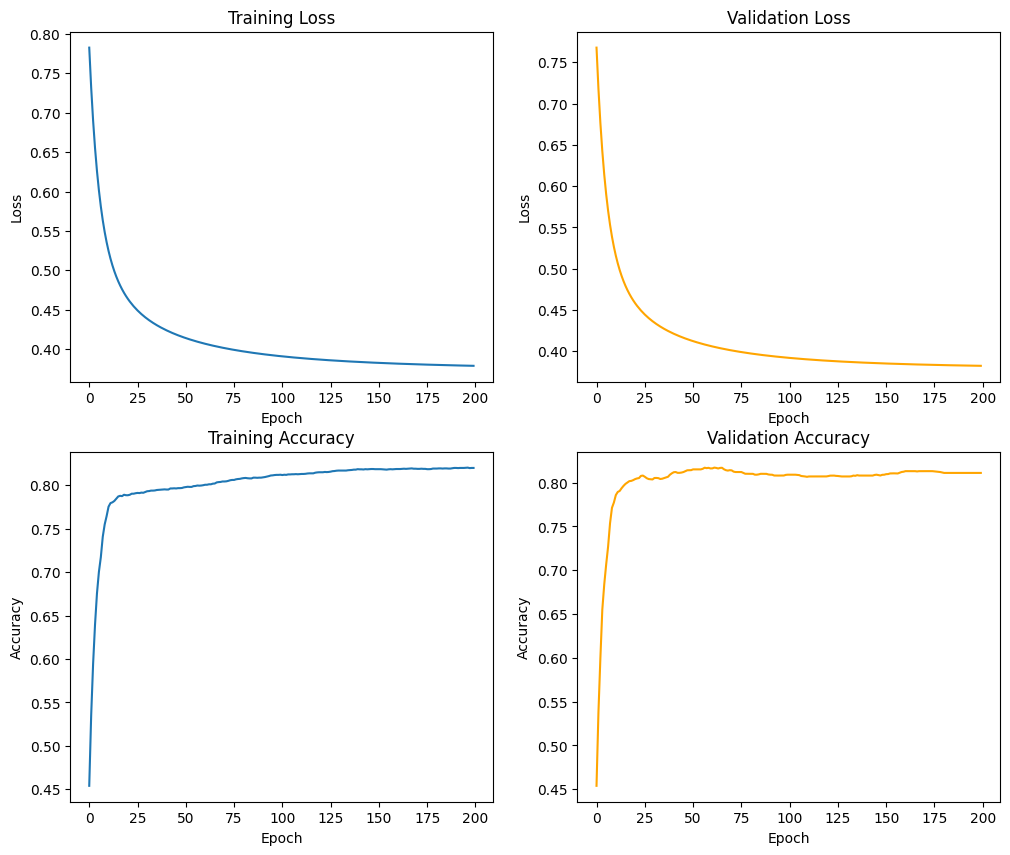

In [103]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()
